In [ ]:
from glob import glob
from emocodes import CodeTimeSeries

raw_dir = '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/raw/'

movie = 'MLP'

if movie=='AHKJ':
    raw_files = glob(raw_dir + 'AHKJ*_subjective_char*')
    video = '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/episodes/AHKJ_S1E2.mp4'
    preproc_dir = '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/processed/AHKJ_S1E2/'
elif movie=='MLP':
    raw_files = glob(raw_dir + 'MLP*_subjective_char*')
    video = '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/episodes/MLP_S8E3_20.mp4'
    preproc_dir = '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/processed/MLP_S8E3/'

cts = CodeTimeSeries(sampling_rate=10)
#raw_files = [raw_dir + 'MLPS8E3_subjective_noncharacter_codes_RK.csv']
for file in raw_files:
    initials = file[-6:-4]
    name_start = file.find('codes_') + len('codes_')
    name_end = file.find('_'+initials)
    char_name = file[name_start:name_end].lower().capitalize()
    print(initials)
    print(char_name)
    cts.proc_codes_file(codes_file=file, video_file=video, save_file_name=preproc_dir+'subjective_character_{1}_timeseries_{0}'.format(initials, char_name))
    #cts.proc_codes_file(codes_file=file, video_file=video, save_file_name=preproc_dir+'subjective_noncharacter_timeseries_{0}'.format(initials))
    

In [103]:
# pull in data and assign processing directories
from glob import glob
preproc_dir = '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/processed/'

#episode = 'AHKJ_S1E2'
episode = 'MLP_S8E3'
string_vars = ['d_other_name']
files = sorted(glob(preproc_dir + '{0}/subjective_nonchar*'.format(episode)))
files

['/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/processed/MLP_S8E3/subjective_noncharacter_timeseries_DB_20210705-133311.csv',
 '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/processed/MLP_S8E3/subjective_noncharacter_timeseries_NS_20210705-133312.csv',
 '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/processed/MLP_S8E3/subjective_noncharacter_timeseries_RK_20210706-081531.csv',
 '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/processed/MLP_S8E3/subjective_noncharacter_timeseries_ja_20210705-133312.csv']

******************* audio_intensity *********************


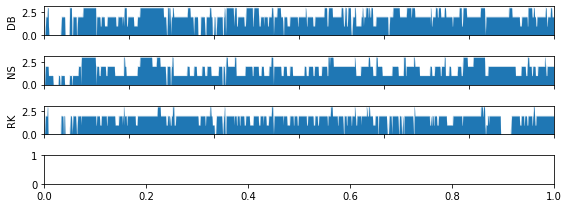

 
******************* audio_valence_negative *********************


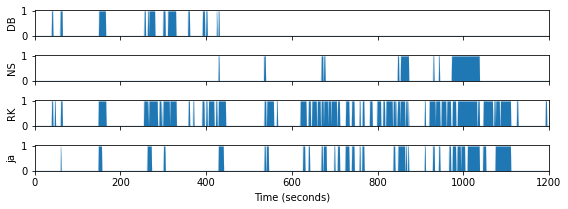

 
******************* audio_valence_positive *********************


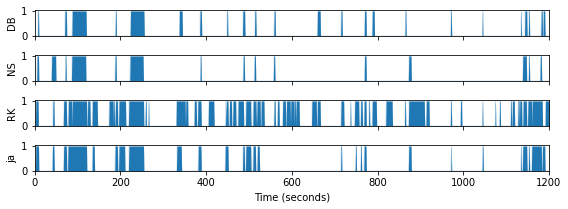

 
******************* visual_degree *********************


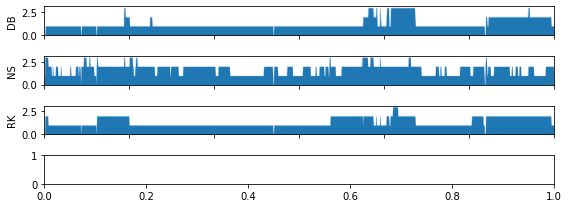

 
******************* visual_valence_negative *********************


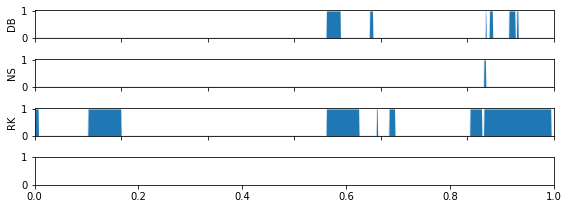

 
******************* visual_valence_positive *********************


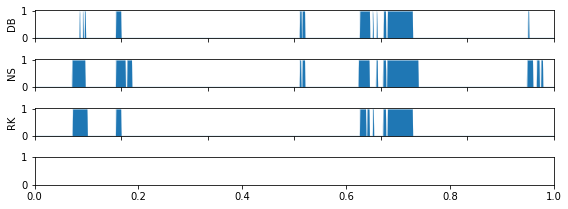

In [105]:
import matplotlib.pyplot as plt
import pandas as pd

dfs = []
raters = []

for file in files:
    rater = file[-22:-20]
    raters.append(rater)
    temp = pd.read_csv(file, index_col=None)
    try:
        temp = temp.drop(string_vars,axis=1)
    except:
        pass
    t = temp['time']/1000
    #temp[temp['on_screen']==0] = 0 # for character codes only
    temp['seconds'] = t
    temp.index = pd.to_datetime(t,unit='s')
    temp.index.name = 'time'
    temp = temp.resample('1s').mean().round(0)
    temp.index = temp['seconds']
    
    dfs.append(temp)

variables = dfs[0].columns[1:-1]
for x in variables:
    print('******************* {0} *********************'.format(x))
    fig, ax = plt.subplots(len(dfs), figsize=(8, 0.75*len(dfs)))
    for i, rates in enumerate(dfs):
        try:
            rates[x].plot(kind='area', ax=ax[i], xlabel='Time (seconds)', ylabel=raters[i], sharex=True, xlim=(0,rates.index[-1]), linewidth=0.1)
        except:
            pass
    plt.tight_layout()
    fig.title = x
    plt.savefig('logs/mlp_subjective_noncharacter_{0}.svg'.format(x))
    plt.show()
    print(' ')

In [106]:
# pull in data and combine into 1 dataframe with a rater column
import pandas as pd

dfs = []
dfs_1hz = []
for file in files:
    rater = file[-22:-20]
    temp = pd.read_csv(file, index_col=None)
    try:
        temp = temp.drop(string_vars,axis=1)
    except:
        pass
    temp.index = pd.to_datetime(temp['time'],unit='ms')
    temp.index.name = 'timeseries'
    temp2 = temp.resample('1s').mean().round(0)
    temp2['rater'] = rater
    dfs_1hz.append(temp2)
    
data1hz = pd.concat(dfs_1hz)
data1hz.columns

Index(['time', 'audio_intensity', 'audio_valence_negative',
       'audio_valence_positive', 'visual_degree', 'visual_valence_negative',
       'visual_valence_positive', 'rater'],
      dtype='object')

In [107]:
# compute ICCs
import pingouin as pg

variables = data1hz.columns.to_list()
variables.remove('rater')
variables.remove('time')
icc_df = pd.DataFrame(columns=['instance_level_ICC', 'instance_level_consistency','overall_mean_ICC'])
for x in variables:
    print('********************* {0} *********************'.format(x))
    icc = pg.intraclass_corr(data=data1hz, targets='time',raters='rater',ratings=x, nan_policy='omit').round(3)
    print(icc.set_index('Type'))
    icc_df.loc[x, 'instance_level_ICC'] = icc.loc[1, 'ICC']
    icc_df.loc[x, 'overall_mean_ICC'] = icc.loc[4, 'ICC']

    # evaluate item-level ICCs
    if icc.loc[1, 'ICC'] < 0.50:
        icc_df.loc[x, 'instance_level_consistency'] = 'poor'
    elif (icc.loc[1, 'ICC'] >= 0.50) & (icc.loc[1, 'ICC'] < 0.75):
        icc_df.loc[x, 'instance_level_consistency'] = 'moderate'
    elif (icc.loc[1, 'ICC'] >= 0.75) & (icc.loc[1, 'ICC'] < 0.90):
        icc_df.loc[x, 'instance_level_consistency'] = 'good'
    elif icc.loc[1, 'ICC'] >= 0.90:
        icc_df.loc[x, 'instance_level_consistency'] = 'excellent'
print('')

********************* audio_intensity *********************
                   Description    ICC      F   df1   df2  pval         CI95%
Type                                                                        
ICC1    Single raters absolute  0.494  3.934  1200  2402   0.0  [0.46, 0.53]
ICC2      Single random raters  0.504  4.446  1200  2400   0.0  [0.44, 0.56]
ICC3       Single fixed raters  0.535  4.446  1200  2400   0.0   [0.5, 0.57]
ICC1k  Average raters absolute  0.746  3.934  1200  2402   0.0  [0.72, 0.77]
ICC2k    Average random raters  0.753  4.446  1200  2400   0.0    [0.7, 0.8]
ICC3k     Average fixed raters  0.775  4.446  1200  2400   0.0   [0.75, 0.8]
********************* audio_valence_negative *********************
                   Description    ICC      F   df1   df2  pval         CI95%
Type                                                                        
ICC1    Single raters absolute  0.216  2.105  1200  3603   0.0  [0.19, 0.25]
ICC2      Single random ra

In [108]:
icc_df.to_csv('logs/iccs_mlp_subjnonchar.csv')